In [ ]:
# Image Classification Using Convolutional Neural Networks (CNNs)
# ---------------------------#
# Reema Aldanish


 <b><font size="5" color='violet'>
Dataset Origin
</font></b>



https://www.kaggle.com/datasets/andrewmvd/animal-faces?resource=download


 <b><font size="5" color='violet'>
Import Libraries
</font></b>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
#Install gdown if not installed,,
!pip install gdown
#Import gdown and download file using Google Drive file ID,,
import gdown
file_id = '1Gn1TDPyV3G-F-2SXeEuJALQVhFa3xleV'
#Download the file,,
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'yourfile.zip', quiet=False)
#Unzip the file,,
import zipfile
with zipfile.ZipFile('yourfile.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files')
#List extracted files,,
import os
extracted_files = os.listdir('/content/extracted_files')
print('Extracted files:', extracted_files)

Downloading...
From (original): https://drive.google.com/uc?id=1Gn1TDPyV3G-F-2SXeEuJALQVhFa3xleV
From (redirected): https://drive.google.com/uc?id=1Gn1TDPyV3G-F-2SXeEuJALQVhFa3xleV&confirm=t&uuid=5b30a71c-8850-428e-b8c0-b9ec1831dca1
To: /content/yourfile.zip
100%|██████████| 730M/730M [00:21<00:00, 34.2MB/s]


Extracted files: ['afhq']


Displaying images from train set:
Displaying images from folder: wild


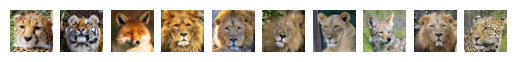

Displaying images from folder: dog


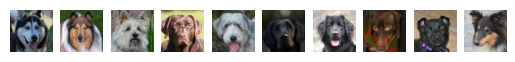

Displaying images from folder: cat


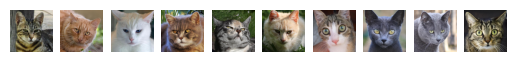

Displaying images from val set:
Displaying images from folder: wild


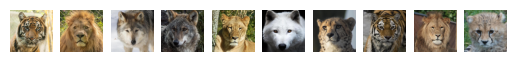

Displaying images from folder: dog


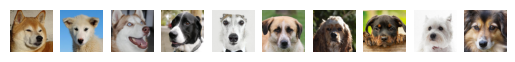

Displaying images from folder: cat


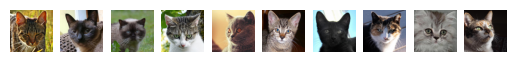

In [ ]:
base_path = '/content/extracted_files/afhq'
def display_images_from_folder(folder_path, num_images=10):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            plt.subplot(1, num_images, i+1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
    plt.show()
for split_folder in ['train', 'val']:
    split_path = os.path.join(base_path, split_folder)
    if os.path.isdir(split_path):
        print(f"Displaying images from {split_folder} set:")
        for folder_name in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder_name)
            if os.path.isdir(folder_path):
                print(f'Displaying images from folder: {folder_name}')
                display_images_from_folder(folder_path)


 <b><font size="5" color='violet'>
Data Preprocessing
</font></b>

Resize all images to a uniform dimension (128x128 pixels).

In [ ]:
TRAIN_DIR='/content/extracted_files/afhq/train'
VAL_DIR='/content/extracted_files/afhq/val'
CATEGORIES=["dog","wild","cat"]
IMG_SIZE=128
all_data=[]
#Load and resize images from a folder,,
def create_data_from_folder(DATADIR):
    data=[]
    for category in CATEGORIES:
        path=os.path.join(DATADIR,category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                resized_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                data.append([resized_array,class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return data
#Load images from train and validation folders,,
training_data=create_data_from_folder(TRAIN_DIR)
val_data=create_data_from_folder(VAL_DIR)
#Merge train and validation data,,
all_data=training_data+val_data
import random
random.shuffle(all_data)
#Split data into images and labels,,
X=[]
y=[]
for features,label in all_data:
    X.append(features)
    y.append(label)
#Convert X and y to NumPy arrays,,
X=np.array(X)
y=np.array(y)
#Display final shapes,,
print(f"Shape of X (Images): {X.shape}")
print(f"Shape of y (Labels): {y.shape}")

Shape of X (Images): (16130, 128, 128, 3)
Shape of y (Labels): (16130,)


Normalize pixel values to the range [0, 1].

In [ ]:
#Normalize pixel values to the range [0, 1],,
X=X/255.0
#Display final shapes after normalization,,
print(f"Shape of X after normalization: {X.shape}")

Shape of X after normalization: (16130, 128, 128, 3)


Convert labels to One-Hot Encoding.

In [ ]:
#Convert labels to One-Hot Encoding,,
y_one_hot=to_categorical(y,num_classes=len(CATEGORIES))
#Display final shape of labels,,
print(f"Shape of labels after One-Hot Encoding: {y_one_hot.shape}")

Shape of labels after One-Hot Encoding: (16130, 3)


 <b><font size="5" color='violet'>
Data splitting
</font></b>

In [ ]:
#Split data into training set (80%) and testing set (20%),,
X_train,X_test,y_train,y_test=train_test_split(X,y_one_hot,test_size=0.2,random_state=42)
#Calculate percentages,,
total_images=len(X_train)+len(X_test)
train_percentage=(len(X_train)/total_images)*100
test_percentage=(len(X_test)/total_images)*100
#Display dataset sizes with percentages,,
print(f"Training set size: {len(X_train)} ({train_percentage:.2f}%)")
print(f"Testing set size: {len(X_test)} ({test_percentage:.2f}%)")

Training set size: 12904 (80.00%)
Testing set size: 3226 (20.00%)




 <b><font size="5" color='violet'>
Model Developing
</font></b>


In [ ]:
#Initialize the CNN model,,
model=Sequential()
#Add first convolutional layer (32 filters, 3x3 kernel, ReLU activation),,
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
#Add Max Pooling layer (2x2),,
model.add(MaxPooling2D(pool_size=(2,2)))
#Add second convolutional layer (64 filters, 3x3 kernel, ReLU activation),,
model.add(Conv2D(64,(3,3),activation='relu'))
#Add Max Pooling layer (2x2),,
model.add(MaxPooling2D(pool_size=(2,2)))
#Add Dropout layer (rate = 0.25),,
model.add(Dropout(0.25))
#Flatten the output from convolutional layers,,
model.add(Flatten())
#Add Dense layer with 128 neurons and ReLU activation,,
model.add(Dense(128,activation='relu'))
#Add Dropout layer (rate = 0.5),,
model.add(Dropout(0.5))
#Add output layer with Softmax activation for multi-class classification,,
model.add(Dense(3,activation='softmax'))
#Compile the model,,
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Display the model summary,,
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


 <b><font size="5" color='violet'>
Model Training
</font></b>

In [ ]:
#Train the CNN model on training dataset,,
history = model.fit(
    X_train,  #Training data
    y_train,  #Labels for training set
    epochs=10,  #Number of epochs to train the model
    batch_size=32,  #Batch size during training
    validation_data=(X_test, y_test),  #Validation data taken from the test set
    verbose=1  #Print training progress
)
#Evaluate the model on the test set,,
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6971 - loss: 0.7467 - val_accuracy: 0.9386 - val_loss: 0.1918
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9338 - loss: 0.1928 - val_accuracy: 0.9454 - val_loss: 0.1537
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9589 - loss: 0.1175 - val_accuracy: 0.9594 - val_loss: 0.1257
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9697 - loss: 0.0823 - val_accuracy: 0.9572 - val_loss: 0.1245
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9799 - loss: 0.0530 - val_accuracy: 0.9628 - val_loss: 0.1287
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9853 - loss: 0.0404 - val_accuracy: 0.9616 - val_loss: 0.1275
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9885 - loss: 0.0321 - val_accuracy: 0.9631 - val_loss: 0.1197
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9900 - loss: 0.0324 - val_acc

 <b><font size="5" color='violet'>
Optimize hyperparameters
</font></b>

In [ ]:
#Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Convert labels to One-Hot Encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
#Check if dimensions are correct
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train after One-Hot Encoding: {y_train_one_hot.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test after One-Hot Encoding: {y_test_one_hot.shape}")
#List to store results
results = []
#Experiment with different learning rates and filters
learning_rates = [0.0001]  #Lower learning rate for finer adjustments
num_filters = [64]  #Increase the number of filters
num_epochs = [10]  #Increase the number of epochs
batch_sizes = [32]  #Smaller batch size for better gradient updates
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
#Experiment with different architectures
for lr in learning_rates:
    for filters in num_filters:
        for epochs in num_epochs:
            for batch_size in batch_sizes:
                #Build the model
                model = Sequential()
                model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(128, 128, 3)))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(0.25))  #Adding dropout to prevent overfitting
                model.add(Conv2D(filters * 2, (3, 3), activation='relu'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(0.25))  #More dropout
                model.add(Conv2D(filters * 4, (3, 3), activation='relu'))  #Added a deeper layer
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(0.5))  #Increased dropout to avoid overfitting
                model.add(Flatten())
                model.add(Dense(256, activation='relu'))  #Increased the number of neurons
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                #Compile the model
                model.compile(optimizer=Adam(learning_rate=lr),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
                #Train the model with Early Stopping and ReduceLROnPlateau
                history = model.fit(X_train, y_train_one_hot,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test, y_test_one_hot),
                                    callbacks=[early_stopping, reduce_lr],
                                    verbose=1)
                #Evaluate the model on the test set
                val_loss, val_acc = model.evaluate(X_test, y_test_one_hot, verbose=0)
                #Store results
                results.append({
                    'learning_rate': lr,
                    'filters': filters,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'validation_accuracy': val_acc,
                    'validation_loss': val_loss
                })
#Print best results
best_result = max(results, key=lambda x: x['validation_accuracy'])
print("Best Hyperparameters:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Number of Filters: {best_result['filters']}")
print(f"Number of Epochs: {best_result['epochs']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Validation Accuracy: {best_result['validation_accuracy']}")
print(f"Validation Loss: {best_result['validation_loss']}")

Shape of X_train: (12904, 128, 128, 3)
Shape of y_train after One-Hot Encoding: (12904, 3)
Shape of X_test: (3226, 128, 128, 3)
Shape of y_test after One-Hot Encoding: (3226, 3)
Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.7013 - loss: 1.1265 - val_accuracy: 0.5809 - val_loss: 2.4755 - learning_rate: 1.0000e-04
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8834 - loss: 0.3095 - val_accuracy: 0.8881 - val_loss: 0.4487 - learning_rate: 1.0000e-04
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9194 - loss: 0.2236 - val_accuracy: 0.9281 - val_loss: 0.2398 - learning_rate: 1.0000e-04
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9454 - loss: 0.1499 - val_accuracy: 0.9547 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9573 - loss: 0.1173 - val_accuracy: 0.9650 - val_loss: 0.1167 - learning_rate: 1.0000e-04
Epoch 6/10
404/404 ━━━━━━━━━━━━━

The second code was improved by incorporating advanced techniques such as reducing the learning rate and using Batch Normalization layers to speed up and stabilize training. The model depth was increased by adding more Convolution layers, increasing the number of filters, and boosting the number of neurons to enhance learning capacity. Additionally, Early Stopping and ReduceLROnPlateau were implemented to reduce training time and improve performance, while Dropout rates were increased to avoid overfitting. Finally, multiple values of hyperparameters were tested to select the best settings for achieving higher accuracy.

 <b><font size="5" color='violet'>
Model Evaluation
</font></b>

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


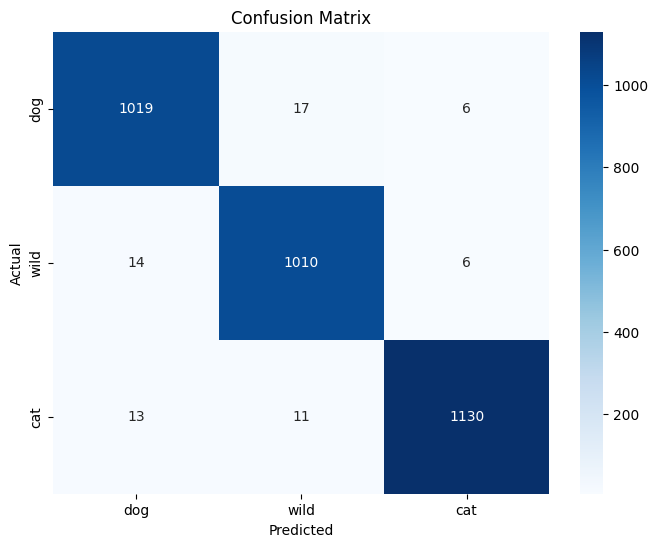

Classification Report:
              precision    recall  f1-score   support

         dog       0.97      0.98      0.98      1042
        wild       0.97      0.98      0.98      1030
         cat       0.99      0.98      0.98      1154

    accuracy                           0.98      3226
   macro avg       0.98      0.98      0.98      3226
weighted avg       0.98      0.98      0.98      3226



In [ ]:
#Get predictions from the model,,
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  #Convert predictions to class labels
y_true_classes = np.argmax(y_test_one_hot, axis=1)  #Get true class labels
#Compute confusion matrix,,
cm = confusion_matrix(y_true_classes, y_pred_classes)
#Plot confusion matrix using heatmap,,
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
#Print classification report,,
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES))

In the first model, a decent accuracy was achieved, but there was still room for improvement. By refining the model in the second version—such as increasing the number of filters, adding more layers, and fine-tuning the learning rate—overall performance improved. These changes enhanced the model's ability to generalize better on unseen data, reducing both validation loss and improving accuracy. The second approach benefited from a more robust architecture and fine-tuned hyperparameters, leading to better classification results.

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


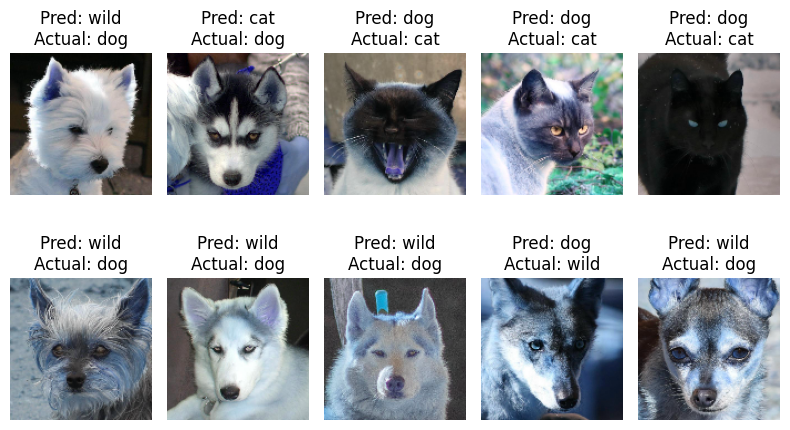

In [ ]:
#Get the predictions from the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  #Convert the predictions to class labels
y_true_classes = np.argmax(y_test_one_hot, axis=1)  #Get the true class labels
#Find the misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
#Plot some misclassified images
num_images_to_display = 10
plt.figure(figsize=(8, 5))
for i, index in enumerate(misclassified_indices[:num_images_to_display]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Pred: {CATEGORIES[y_pred_classes[index]]}\nActual: {CATEGORIES[y_true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

After reviewing the images where the model made incorrect predictions, it was observed that most of the misclassified images contained a noticeable amount of blue and purple shades. Several methods were implemented to improve the model's accuracy, including removing unnatural colors like blue and purple from the entire images, but the accuracy did not change significantly. Then, the unnatural colors were reduced only within the animal faces, but again, there was no improvement in accuracy. Finally, a technique was applied that converts the entire image to grayscale if a certain percentage of unnatural colors was detected, yet the results still did not improve significantly. The model continues to struggle with predictions due to the unnatural colors like blue and purple, leading to misclassifications. These colors require better handling during preprocessing to improve the accuracy, as they remain a challenge that affects the model's performance.

 <b><font size="5" color='violet'>
Testing the model's accuracy with images outside the dataset
</font></b>

Please upload the image file path: /content/R.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted class is: wild


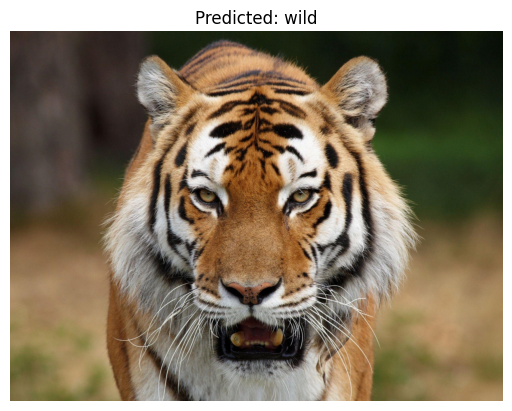

In [ ]:
def load_and_process_image(image_path):
    img = Image.open(image_path)  #Load the image
    img = img.convert("RGB")  #Convert to RGB if it doesn't have 3 channels
    img = img.resize((128, 128))  #Resize image to 128x128
    img_array = np.array(img)  #Convert image to NumPy array
    img_array = img_array / 255.0  #Normalize values to be between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension (1, 128, 128, 3)
    return img_array
#Function to classify the image ,,
def classify_image(image_path):
    processed_image = load_and_process_image(image_path)  #Process the image
    prediction = model.predict(processed_image)  #Predict using the trained model
    predicted_class = np.argmax(prediction, axis=1)  #Get predicted class
    print(f"The predicted class is: {CATEGORIES[predicted_class[0]]}")  #Print predicted class
    img = Image.open(image_path)  #Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {CATEGORIES[predicted_class[0]]}")
    plt.axis('off')
    plt.show()
#Ask user for image file path ,,
image_path = input("Please upload the image file path: ")
#Classify the image ,,
classify_image(image_path)

Please upload the image file path: /content/163165-puppy-dog-face-free-transparent-image-hd.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted class is: dog


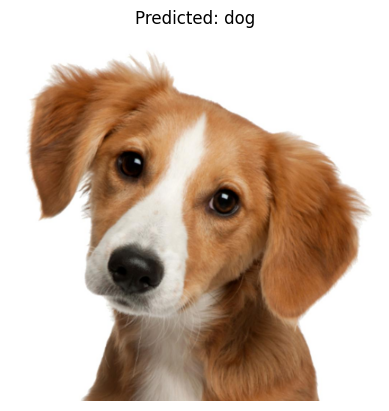

In [ ]:
def load_and_process_image(image_path):
    img = Image.open(image_path)  #Load the image
    img = img.convert("RGB")  #Convert to RGB if it doesn't have 3 channels
    img = img.resize((128, 128))  #Resize image to 128x128
    img_array = np.array(img)  #Convert image to NumPy array
    img_array = img_array / 255.0  #Normalize values to be between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension (1, 128, 128, 3)
    return img_array
#Function to classify the image ,,
def classify_image(image_path):
    processed_image = load_and_process_image(image_path)  #Process the image
    prediction = model.predict(processed_image)  #Predict using the trained model
    predicted_class = np.argmax(prediction, axis=1)  #Get predicted class
    print(f"The predicted class is: {CATEGORIES[predicted_class[0]]}")  #Print predicted class
    img = Image.open(image_path)  #Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {CATEGORIES[predicted_class[0]]}")
    plt.axis('off')
    plt.show()
#Ask user for image file path ,,
image_path = input("Please upload the image file path: ")
#Classify the image ,,
classify_image(image_path)

Please upload the image file path: /content/18-cute-angry-kitten-funny.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted class is: cat


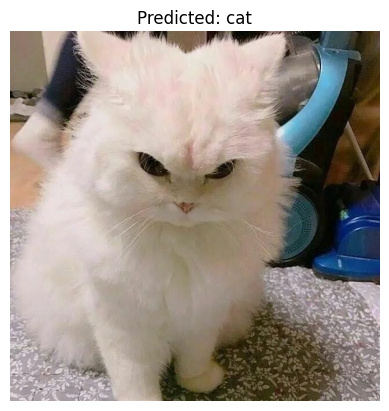

In [ ]:
def load_and_process_image(image_path):
    img = Image.open(image_path)  #Load the image
    img = img.convert("RGB")  #Convert to RGB if it doesn't have 3 channels
    img = img.resize((128, 128))  #Resize image to 128x128
    img_array = np.array(img)  #Convert image to NumPy array
    img_array = img_array / 255.0  #Normalize values to be between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension (1, 128, 128, 3)
    return img_array
#Function to classify the image ,,
def classify_image(image_path):
    processed_image = load_and_process_image(image_path)  #Process the image
    prediction = model.predict(processed_image)  #Predict using the trained model
    predicted_class = np.argmax(prediction, axis=1)  #Get predicted class
    print(f"The predicted class is: {CATEGORIES[predicted_class[0]]}")  #Print predicted class
    img = Image.open(image_path)  #Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {CATEGORIES[predicted_class[0]]}")
    plt.axis('off')
    plt.show()
#Ask user for image file path ,,
image_path = input("Please upload the image file path: ")
#Classify the image ,,
classify_image(image_path)



---





---

